In [1]:
import json 
import os
import os.path as path
from pprint import pprint
import re
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# directories
logs_dir = "../logs"
output_dir = "../reddit-data"
posts_dir = path.join(output_dir, "posts")
comments_dir = path.join(output_dir, "comments")

## Posts

### Scraping overview

In [3]:
# prepwork
filenames = sorted(os.listdir(posts_dir))
filepaths = [path.join(posts_dir, fname) for fname in filenames]
dates = [path.splitext(fname)[0] for fname in filenames]

# scraping logs
fpath = path.join(logs_dir, "reddit-posts.log")
logs = {}

with open(fpath, 'r') as f:
    for line in f:

        if line.startswith("Currently on: "):
            date = line[-11:-1]
            logs[date] = {
                "n_posts_available": 0,
                "n_posts_notfound": 0,
                "time_taken": 0,
            }
            continue

        m = re.search("(\d+) result\(s\) available", line)
        if m:
            logs[date]["n_posts_available"] = int(m.group(1))
            continue

        m = re.search("(\d+) result\(s\) not found", line)
        if m:
            logs[date]["n_posts_notfound"] = int(m.group(1))
            continue

        m = re.search("Time taken: (\d+\.?\d+)s", line)
        if m:
            logs[date]["time_taken"] = float(m.group(1))
            continue

Number of files: 731
Number of empty files: 55



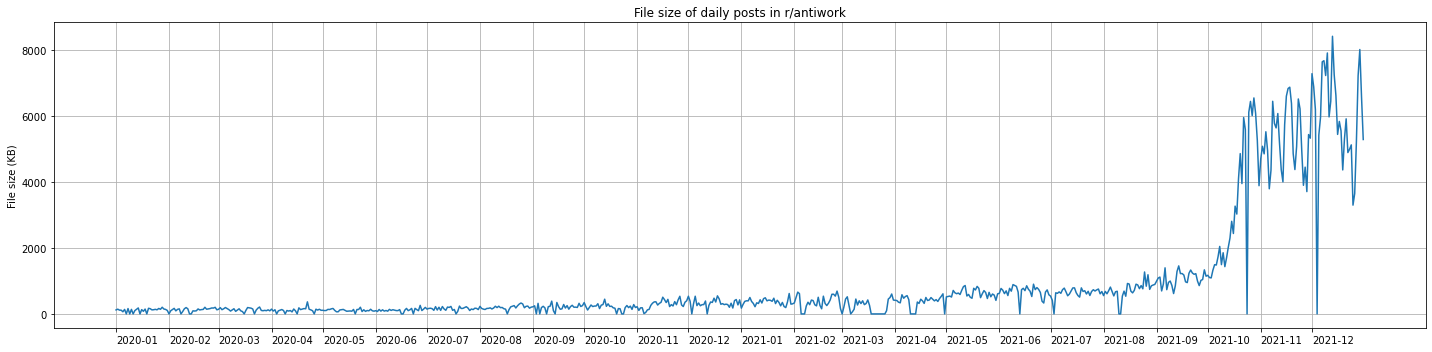

In [4]:
# file sizes
filesizes = np.array([path.getsize(fpath) for fpath in filepaths]) / 1024
print(f"Number of files: {len(filesizes)}")
print(f"Number of empty files: {sum(filesizes == 0)}\n")

if True:
    plt.figure(figsize=(20, 5))
    plt.plot(filesizes)

    plt.title("File size of daily posts in r/antiwork")
    plt.ylabel("File size (KB)")
    plt.tick_params(axis='x')
    plt.xticks(
        ticks=[i for i in range(len(dates)) if dates[i].endswith("01")], 
        labels=[date[:-3] for date in dates if date.endswith("01")], 
        ha="left")
    plt.grid()
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_551309/853195071.py:8: RuntimeWarning: invalid value encountered in true_divide
  frac_posts_notfound = n_posts_notfound / n_posts_available


Number of dates with no posts available: 55
Number of dates with posts not found: 125
Number of posts not found: 173
Max. number of posts not found on any one date: 5



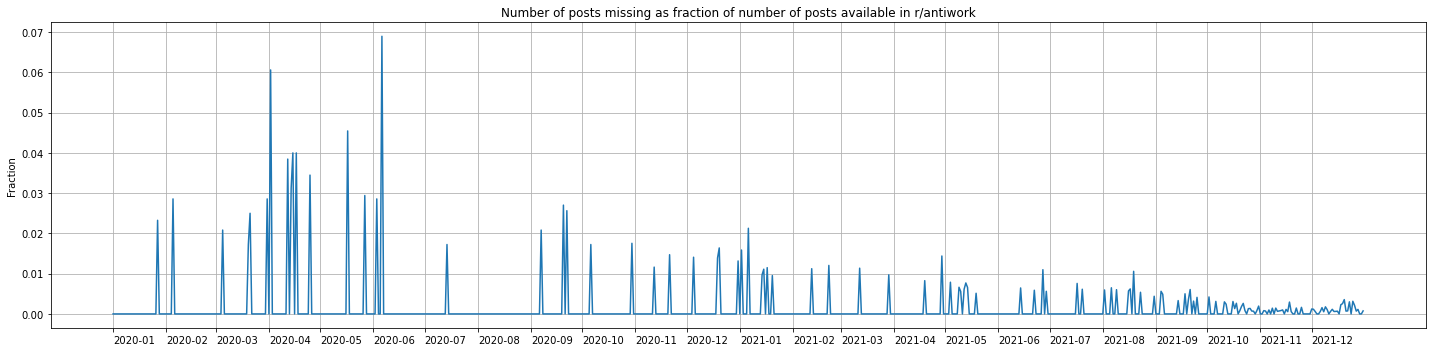

In [6]:
# number of posts not found vs. number of posts available
# manually check with this website: https://redditsearch.io
n_posts_available = np.array(
    [logs[date]["n_posts_available"] for date in dates])
n_posts_notfound = np.array(
    [logs[date]['n_posts_notfound'] for date in dates])

frac_posts_notfound = n_posts_notfound / n_posts_available
frac_posts_notfound = np.nan_to_num(frac_posts_notfound, 0)

print(f"Number of dates with no posts available: {sum(n_posts_available == 0)}")
print(f"Number of dates with posts not found: {sum(n_posts_notfound != 0)}")
print(f"Number of posts not found: {sum(n_posts_notfound)}")
print(f"Max. number of posts not found on any one date: {max(n_posts_notfound)}\n")

if True:
    plt.figure(figsize=(20, 5))
    plt.plot(frac_posts_notfound)

    plt.title("Number of posts not found as fraction of number of posts available in r/antiwork")
    plt.ylabel("Fraction")
    plt.tick_params(axis='x')
    plt.xticks(
        ticks=[i for i in range(len(dates)) if dates[i].endswith("01")], 
        labels=[date[:-3] for date in dates if date.endswith("01")], 
        ha="left")
    plt.grid()
    plt.tight_layout()
    plt.show()

Min. time taken per date: 0.23s
Med. time taken per date: 13.42s
Max. time taken per date: 130.00s

Cumulative time taken: 12010.72s


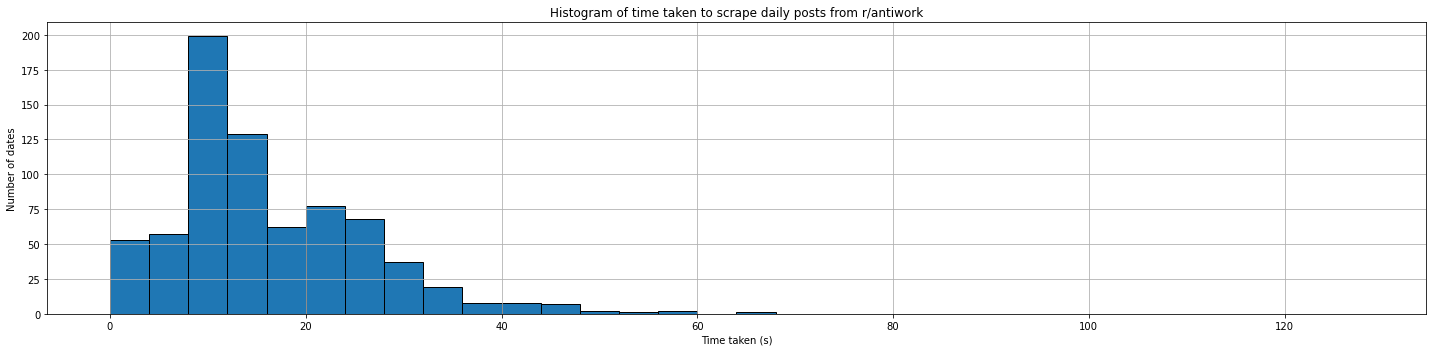

In [7]:
# time taken
time_taken = np.array([logs[date]["time_taken"] for date in dates])

print(f"Min. time taken per date: {time_taken.min():.2f}s")
print(f"Med. time taken per date: {np.median(time_taken):.2f}s")
print(f"Max. time taken per date: {time_taken.max():.2f}s\n")
print(f"Cumulative time taken: {sum(time_taken):.2f}s")

if True:
    plt.figure(figsize=(20, 5))
    plt.hist(time_taken, bins=range(0, 131, 4), edgecolor="black")

    plt.title("Histogram of time taken to scrape daily posts from r/antiwork")
    plt.ylabel("Number of dates")
    plt.xlabel("Time taken (s)")
    plt.grid()
    plt.tight_layout()
    plt.show()

### Initial exploration

In [8]:
# peek at sample
with open(filepaths[-1], 'r') as f:
    for line in f:
        x = json.loads(line)
        break
pprint(x)

{'all_awardings': [],
 'allow_live_comments': False,
 'author': 'ClownPrince_1939',
 'author_flair_css_class': None,
 'author_flair_richtext': [],
 'author_flair_text': None,
 'author_flair_type': 'text',
 'author_fullname': 't2_aulum8lp',
 'author_is_blocked': False,
 'author_patreon_flair': False,
 'author_premium': False,
 'awarders': [],
 'can_mod_post': False,
 'contest_mode': False,
 'created_utc': 1640913453,
 'domain': 'self.antiwork',
 'full_link': 'https://www.reddit.com/r/antiwork/comments/rshmro/yall_are_gonna_learn_that_acting_like_a_spiked/',
 'gildings': {},
 'id': 'rshmro',
 'is_created_from_ads_ui': False,
 'is_crosspostable': True,
 'is_meta': False,
 'is_original_content': False,
 'is_reddit_media_domain': False,
 'is_robot_indexable': True,
 'is_self': True,
 'is_video': False,
 'link_flair_background_color': '',
 'link_flair_richtext': [],
 'link_flair_text_color': 'dark',
 'link_flair_type': 'text',
 'locked': False,
 'media_only': False,
 'no_follow': True,
 'num

In [15]:
keys = ['title', 'selftext', 'id', 'author', 'created_utc', 'score']
date_to_posts = {date: [] for date in dates}
date_to_deleted = {date: [] for date in dates}

for date, fpath in tqdm(zip(dates, filepaths)):

    posts = []
    with open(fpath, 'r') as f:
        for line in f:
            x = json.loads(line)
            if 'removed_by_category' in x: 
                date_to_deleted[date].append(x) # post is removed/deleted
            else:
                date_to_posts[date].append({key: x[key] for key in keys})

731it [00:08, 90.50it/s] 


In [10]:
# deleted posts
n_deleted = {date: len(deleted) for date, deleted in date_to_deleted.items()}

print(f"Number of deleted posts: {sum(n_deleted.values())}")
print(f"Max. number of posts deleted from any one date: {max(n_deleted.values())}")
print(f"Creation date with most posts deleted: {max(n_deleted, key=lambda k: n_deleted[k])}\n")
print(f"Examples")
for post in date_to_deleted[max(n_deleted, key=lambda k: n_deleted[k])][:10]:
    print(f"- {post['title']}")

Number of deleted posts: 60
Max. number of posts deleted from any one date: 17
Creation date with most posts deleted: 2021-12-08

Examples
- What should I do? In regards to a part time gig??
- Imagine being fired on zoom call
- Anti-work 🤣🤣🤣🤣 What a bunch of weird creatures people are. If you don’t want to work to provide the lifestyle you wish to attain then you’re as good as dead 😂
- I quit work 3 weeks ago because of the passive income I'm earning from making memes... and you can do it too, for free. HEAR ME OUT
- What happened at your work which caused multiple people to all quit at once?
- Feeling excluded? You are not alone.
- Inspired by the same thread that was dominated by Americans, Non-Americans, What is your job and how much do you make from it (If possible, include your local currency and US Dollars)?
- I don't get antiwork
- Are most of your really this dumb or are you all just bots?
- If anyone wants to help me never work again my cashapp is right here! $northstarmoney


Number of posts: 731
Max. number of posts created in one day: 1753


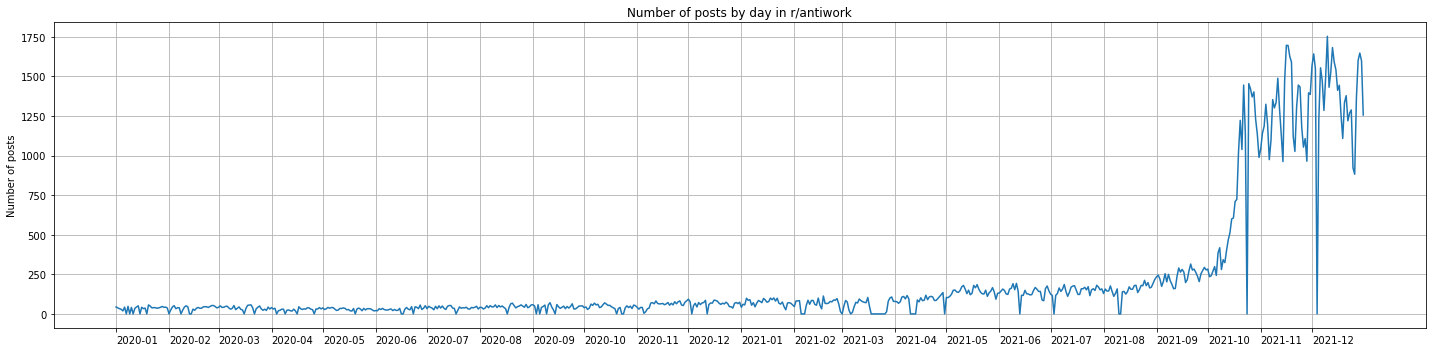

In [24]:
# number of posts by date
n_posts = np.array([len(date_to_posts[date]) for date in dates])
print(f"Number of posts: {len(n_posts)}")
print(f"Max. number of posts created in one day: {n_posts.max()}")

if True:
    plt.figure(figsize=(20, 5))
    plt.plot(n_posts)

    plt.title("Number of posts by day in r/antiwork")
    plt.ylabel("Number of posts")
    plt.tick_params(axis='x')
    plt.xticks(
        ticks=[i for i in range(len(dates)) if dates[i].endswith("01")], 
        labels=[date[:-3] for date in dates if date.endswith("01")], 
        ha="left")
    plt.grid()
    plt.tight_layout()
    plt.show()

Min. number of characters: 1
Med. number of characters: 145.0
Max. number of characters: 39690


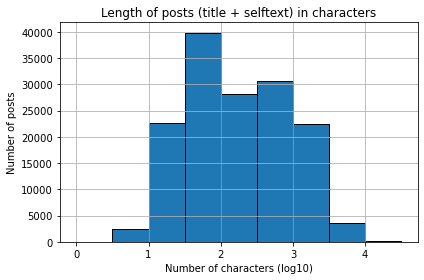

In [39]:
n_chars = []
for date in dates:
    posts = date_to_posts[date]
    n_chars.extend([len(p['title'] + p['selftext']) for p in posts])
n_chars = np.array(n_chars)

print(f"Min. number of characters: {n_chars.min()}")
print(f"Med. number of characters: {np.median(n_chars)}")
print(f"Max. number of characters: {n_chars.max()}")

if True:
    plt.hist(np.log10(n_chars), edgecolor='black', bins=np.array(range(0,50,5))/10)

    plt.title("Length of posts (title + selftext) in characters")
    plt.xlabel("Number of characters (log10)")
    plt.ylabel("Number of posts")
    plt.grid()
    plt.tight_layout()
    plt.show()